Extensions of Differences-in-Differences Models: Applications with STATA
---

**Zhiyuan Chen**

*Renmin Business School*

`Recent Update: 2024-4-11`

`First Version: 2022-05-10`



This material is perpared for graduate course of Emprical Methods. Usual copyrights statements apply.


# Overview 
* [Simulation Setup](#simulation_setup)
    
* [Applications of Different Techniques](#application)
    * Canonical Diff-In-Diff
    * PSM-DID
    * Semiparametric-DID
    * Synthetic DID
* [Alternative Experiments](#alternatives)
    * Heterogenous Treatment Effects
    * Selection on Unobservables
* [Staggered Diff-In-Diffs](#stagger_did)

# Simulation Setup <a class="anchor" id="simulation_setup"></a>

## A Model of Treatment and Potential Outcomes
Consider the two-group and two-period model with potential outcomes determined as:
$$
y_{it}^j = \tau_{i} \cdot D_{it} +h^j(x_{it})+\lambda_i + \delta \cdot t +u_{it}^j,\quad j\in \{0,1\}; t\in \{0,1\}
$$
* $y_{it}$ is unit $i$'s income in period $t$; $D_{it}\in\{0,1\}$ is the treatment indicator
* $j=1$ means attend Chen's RMEB class and zero if not 
* $\tau_i$ is the treatment effects that can differ across units
* $h^j(x_{it}), \lambda_i, \delta_t$ are covariates. Specifically, $x_{it}$ means $i$'s ability

> **[Parallel Trend or CIA Assumption]**: $(u_{it}^1-u_{it}^0) \perp D_{it} | x_{it}$

This setting covers a large class of empirical models in various areas.

## DGP 
We generate a two-period panel data according to following DGPs:
* Number of observations = 200, $t=0,1$
* $h^j(x_{it}) = \alpha_1 \cdot x_{it} + \alpha_2\cdot x_{it}^2$ and $\alpha_1 = 0.1; \alpha_2 = 0.2$
* $x_{it}\sim N(0, 1)$, $\lambda_i\sim  N(0-0.1\times D_{it},0.5^2)$, $\delta=0.1$
* $u_{it}^j\sim N(0, 0.2^2)$ for $j\in\{0,1\}$
* **Hoomogeneous Treatment Effects**: $\tau_{i}=0.15$ if treated, then $ATT^{true}=0.15$
* **Selection into treatment**: $D_{i0}=0$ and 
$$
D_{i1} = 1 \quad if \quad x_{i0}-v>0
$$
where $v\sim N(\mu_v, 1)$ is independent of $x_{it}$ and $u_{it}^0$, we let $\mu_v$ differ across different settings
* $y_{it}^j = \tau_{i} \cdot D_{it} +h^j(x_{it})+\lambda_i + \delta \cdot t +u_{it}^j$

In [1]:
*Stata Code for data simulation
clear all 
set seed 10101
set obs 500 //number of observations (what if the # of observations is smaller?)
g id = _n 
g lambda = rnormal(0,0.5) //individual fixed effects
expand 2 // expand them to be two periods
bys id: g t = _n-1 //generate periods 
g x = rnormal(0,1)
g u1 = rnormal(0,0.2)
g u0 = rnormal(0,0.2)
g v = rnormal(0,1) if t==1 // random error on selection (What happens if se(v) is small?)
scalar delta = 0.1 //exogenous trend
scalar alpha1 = 0.1
scalar alpha2 = 0.2
g y0 = alpha1*x + alpha2*x^2 + lambda + delta*t+u0
g y1 = alpha1*x + alpha2*x^2 + lambda + delta*t+u1 
g D = 0
bys id (t): replace D=1 if t==1&x>v //selection into treated
g tau_u = 0.15 if D==1 //constant treatment effects
replace tau_u = 0 if missing(tau_u)
replace y1 = y1 + tau_u if D==1 
bys id (t): replace y0 = y0 - 0.1 if D[_N]==0 //different levels 
g y = D*y1+(1-D)*y0
save simdata_did1.dta,replace




number of observations (_N) was 0, now 500



(500 observations created)





(500 missing values generated)







(253 real changes made)

(747 missing values generated)

(747 real changes made)

(253 real changes made)

(494 real changes made)


file simdata_did1.dta saved


### 1. Two-way fixed Effects Model

We estimate three FE models using OLS:

$$
y_{it} = \tau D_{it}+\lambda_i +\delta t + \epsilon_{it} \tag{1}
$$

$$
y_{it} = \tau D_{it}+\lambda_i +\delta t + \epsilon_{it} \tag{2}
$$

$$
y_{it} = \tau D_{it}+\alpha_1 \cdot x_{it}+\alpha_2 \cdot x_{it}^2 + \lambda_i +\delta t + \epsilon_{it} \tag{3}
$$

In [2]:
xtset id t
g x2 = x^2


       panel variable:  id (strongly balanced)
        time variable:  t, 0 to 1
                delta:  1 unit



In [3]:
qui xtreg y D t, fe vce(robust)
est sto fe1
qui xtreg y D x t, fe vce(robust)
est sto fe2 
qui xtreg y D x x2 t, fe vce(robust)
est sto fe3

In [4]:
%html
esttab fe1 fe2 fe3, se nogaps star(** 0.05 *** 0.01) title("TWFE") html

This front-end or document format cannot display HTML

### 2. PSM-DID

#### Estimation procedures:
1. `Step 1`: specify the model of treatment participation $Pr(D_{i1}=1|x_{i0})$. We try linear and non-linear terms of $x_{i0}$
2. `Step 2`: Perform matching based on the propensity scores 
3. `Step 3`: Define the outcome variable as $\Delta y_{i}=y_{i1}-y_{i0}$, calculate treatment effects as $\Delta y_{i}^1 - \Delta y_{i,match}^0$ for all treated units; obtain analytical standard errors

In [5]:
//step 1: estimating propensity score 
qui probit D x  if t==1 //linear 
cap drop pr1
predict pr1 if t==1
est sto prob1
qui probit D x x2 if t==1  //non-linear 
cap drop pr2
predict pr2 if t==1
est sto prob2




(option pr assumed; Pr(D))
(500 missing values generated)




(option pr assumed; Pr(D))
(500 missing values generated)



In [6]:
%html
esttab prob1 prob2, se nogaps star(** 0.05 *** 0.01) title("First-Step Propensity Score") html

This front-end or document format cannot display HTML

**Overlapping Assumption**
To make the units comparable, we require the **Overlapping Assumption**:
$$
0< Pr(D_{i1}|X_{i0})<1
$$

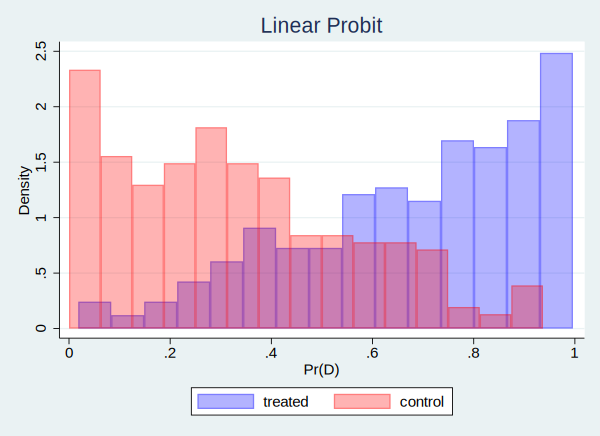

In [7]:
//check overlapping assumption 
twoway hist pr1 if t==1&D==1,color(blue%30) || hist pr1 if t==1&D==0, color(red%30) legend(order(1 "treated" 2 "control")) title("Linear Probit")

### Propensity Score Matching without DID
We use level outcome $y_{it}$ by implementing following commands:
 * `psmatch2`
 * `teffects`

In [8]:
* We use the nearest-neighbor matching with replacement 
psmatch2 D x if t==1, n(2) out(y) quietly


--------------------------------------------------------------------------------
> --------
        Variable     Sample |    Treated     Controls   Difference         S.E. 
>   T-stat
----------------------------+---------------------------------------------------
> --------
               y  Unmatched | .466664109   .175372276   .291291833   .052477601 
>     5.55
                        ATT | .466664109   .264482394   .202181715   .105557501 
>     1.92
----------------------------+---------------------------------------------------
> --------
Note: S.E. does not take into account that the propensity score is estimated.

           | psmatch2:
 psmatch2: |   Common
 Treatment |  support
assignment | On suppor |     Total
-----------+-----------+----------
 Untreated |       247 |       247 
   Treated |       253 |       253 
-----------+-----------+----------
     Total |       500 |       500 


In [9]:
* We use the nearest-neighbor matching with replacement 
** (1) PSM without DID 
teffects psmatch (y) (D x, probit) if t==1,atet nn(2) vce(robust)


Treatment-effects estimation                   Number of obs      =        500
Estimator      : propensity-score matching     Matches: requested =          2
Outcome model  : matching                                     min =          2
Treatment model: probit                                       max =          2
------------------------------------------------------------------------------
             |              AI Robust
           y |      Coef.   Std. Err.      z    P>|z|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
ATET         |
           D |
   (1 vs 0)  |   .2021817    .089678     2.25   0.024      .026416    .3779474
------------------------------------------------------------------------------


### Propensity Score Matching-DID
We use differenced outcomes to construct DID estimator.

In [10]:
g dy = y - l.y

(500 missing values generated)


In [11]:
** (2) PSM with DID 
teffects psmatch (dy) (D x, probit) if t==1,atet nn(2) vce(robust)


Treatment-effects estimation                   Number of obs      =        500
Estimator      : propensity-score matching     Matches: requested =          2
Outcome model  : matching                                     min =          2
Treatment model: probit                                       max =          2
------------------------------------------------------------------------------
             |              AI Robust
          dy |      Coef.   Std. Err.      z    P>|z|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
ATET         |
           D |
   (1 vs 0)  |   .1466702    .077604     1.89   0.059    -.0054309    .2987713
------------------------------------------------------------------------------


In [12]:
teffects psmatch (dy) (D x, probit) if t==1,atet nn(1) vce(robust)


Treatment-effects estimation                   Number of obs      =        500
Estimator      : propensity-score matching     Matches: requested =          1
Outcome model  : matching                                     min =          1
Treatment model: probit                                       max =          1
------------------------------------------------------------------------------
             |              AI Robust
          dy |      Coef.   Std. Err.      z    P>|z|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
ATET         |
           D |
   (1 vs 0)  |     .10565   .0898498     1.18   0.240    -.0704523    .2817523
------------------------------------------------------------------------------


In [14]:
teffects psmatch (dy) (D x, probit) if t==1,atet nn(3) vce(robust)


Treatment-effects estimation                   Number of obs      =        500
Estimator      : propensity-score matching     Matches: requested =          3
Outcome model  : matching                                     min =          3
Treatment model: probit                                       max =          3
------------------------------------------------------------------------------
             |              AI Robust
          dy |      Coef.   Std. Err.      z    P>|z|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
ATET         |
           D |
   (1 vs 0)  |   .1332946   .0696606     1.91   0.056    -.0032376    .2698268
------------------------------------------------------------------------------


In [31]:
psmatch2 D x if t==1, n(2) out(dy) quietly


--------------------------------------------------------------------------------
> --------
        Variable     Sample |    Treated     Controls   Difference         S.E. 
>   T-stat
----------------------------+---------------------------------------------------
> --------
              dy  Unmatched | .287821381   -.00235054   .290171921   .045835582 
>     6.33
                        ATT | .287821381   .141151141   .146670239   .094146201 
>     1.56
----------------------------+---------------------------------------------------
> --------
Note: S.E. does not take into account that the propensity score is estimated.

           | psmatch2:
 psmatch2: |   Common
 Treatment |  support
assignment | On suppor |     Total
-----------+-----------+----------
 Untreated |       247 |       247 
   Treated |       253 |       253 
-----------+-----------+----------
     Total |       500 |       500 


#### Choosing # of Matching Neighbors

There is a bias-variance trade-off:
> As we increase the number of matching neighbors, the bias increases and the variance decreases

It is important to find appropriate number of neighbors in performing matching estimators.

In [ ]:
matrix Res = J(10,3,.) //result matrix
forv i=1/10 {
    qui teffects psmatch (dy) (D x, probit) if t==1,atet nn(`i') vce(robust)
    scalar att = e(b)[1,1]
    scalar att_se = e(V)[1,1]
    matrix Res[`i',1] = (att, att_se, `i')
}
drop _all 
set obs 10
svmat double Res, names(c)
save Res.dta,replace 
clear matrix 

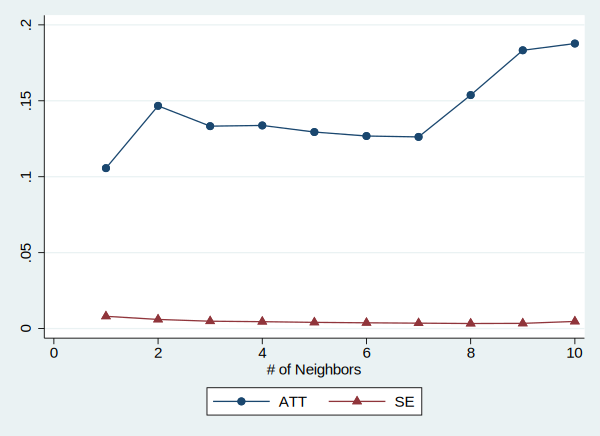

In [76]:
twoway connected c1 c3 || connected c2 c3, m(T) legend(order(1 "ATT" 2 "SE")) ///
       xtitle("# of Neighbors")

### Takeaways of simulation results

* For Diff-In-Diffs Model work well, it is essential that the model is correctly specified
* PSM-DID and linear Diff-In-Diffs Models can generate very distinct results:
    * They put weights on treated observations in a different way
* PSM-DID not necessarily generate better outcomes; the number of matching neighbors is very important in practice

### 3. Semi-parametric DID
The semi-parametric DID method uses **inverse probability weighting**:
$$
ATT = E\left[\frac{y_{i1}-y_{i0}}{P(D_{i1}=1)}\cdot \frac{D_{i1}-P(D_{i1}=1|x_{i1})}{1-P(D_{i1}=1|x_{i1})}\right]
$$

We use two methods to implement it:
* Self-calculating 
* Use the `absdid` command

#### (1) Self-calculating ATT

In [ ]:
//first obtain probabilities 
use simdata_did1.dta, clear 
qui logit D x  if t==1 //linear 
cap drop pr1
predict pr1 if t==1
egen pD = mean(D) if t==1
tsset id t
gen ab_diff = (y-l.y)/pD * ((D-pr1)/(1-pr1)) if t==1
qui sum ab_diff if t==1
scalar ATT_semi = r(mean)
scalar se = r(sd)

In [99]:
matrix abs_res = J(1,2,.)
matrix abs_res[1,1] = (ATT_semi, se)
matrix colnames  abs_res = semi-ATT SE 
matrix rownames abs_res = Stats

In [100]:
matrix list abs_res


abs_res[1,2]
        semi-ATT         SE
Stats  .13759573  2.1811375


* The ATT is plausible and being close to 0.15
* The Standard Error is problematic

#### (2) Use the `absdid` Command

In [102]:
g dy = y - l.y
absdid dy, tvar(D) xvar(x) sle 
//Note: sle specifies the logistic probability model


(500 missing values generated)


Abadie's semi-parametric diff-in-diff           Number of obs     =        500

------------------------------------------------------------------------------
          dy |      Coef.   Std. Err.      z    P>|z|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
ATT          |
       _cons |   .1375957   .0884502     1.56   0.120    -.0357634    .3109548
------------------------------------------------------------------------------


### 4. Synthetic DID
The **synthetic DID** method basically combines *synthetic control method* and *Diff-in-Diff* technique to weaken the reliance on parallel trend assumption.

#### Basic procedures:

1. Find weights {$\hat{\omega}_i^{sc}$} to minimize the difference in selected characteristics (outcome, etc.) for all pre-trend periods
2. Then use the weights in a basic panel data DID regression
$$
({\hat{\delta}^{sdid}},\hat{\mu},\hat{\alpha}_i,\hat{\beta}_t) = \text{argmin}_{\delta,\mu,\alpha_i,\beta_t} \left\{\sum_{i=1}^N\sum_{t=1}^T(Y_{it}-\mu - \alpha_i - \beta_t -\delta D_{it})^2 {\hat{\omega}_i^{sc}}\right\}
$$

The estimation is implemented using `sdid` in Stata

In [117]:
g x2 = x^2

In [189]:
sdid y id t D, covariates(x x2, projected) vce(bootstrap) seed(123)
//graph option is not working well

Bootstrap replications (50). This may take some time.
----+--- 1 ---+--- 2 ---+--- 3 ---+--- 4 ---+--- 5
..................................................     50


Synthetic Difference-in-Differences Estimator

-----------------------------------------------------------------------------
           y |     ATT     Std. Err.     t      P>|t|    [95% Conf. Interval]
-------------+---------------------------------------------------------------
   treatment |   0.16023    0.02509     6.39    0.000     0.11105     0.20941
-----------------------------------------------------------------------------
95% CIs and p-values are based on Large-Sample approximations.
Refer to Arkhangelsky et al., (2020) for theoretical derivations.


In [ ]:
//extracting the unit weights 
g omega = . 
qui sum D if t==1&D==0
qui forv i = 1/`r(N)'{
    scalar uw = e(omega)[`i',1]
    scalar ctr_id = e(omega)[`i',2]
    replace omega = uw if id == ctr_id
}

In [188]:
g x_proj = x*omega 
ta t,sum(x_proj)


(506 missing values generated)


            |          Summary of x_proj
          t |        Mean   Std. Dev.       Freq.
------------+------------------------------------
          0 |   .00020922   .00429042         247
          1 |  -.00217894   .00324052         247
------------+------------------------------------
      Total |  -.00098486   .00398167         494


In [ ]:
ta t if omega==.,sum(x)


            |            Summary of x
          t |        Mean   Std. Dev.       Freq.
------------+------------------------------------
          0 |   .00510224   1.0798278         253
          1 |   .58409887   .77642941         253
------------+------------------------------------
      Total |   .29460055   .98318831         506


# Alternative Experiments <a class="anchor" id="#alternatives"></a>
* Heterogenous Treatment Effects
* Selection on Unobservables

### Heterogenous Treatment Effects: DGP

We generate a two-period panel data according to following DGPs:
* Number of observations = 500, $t=0,1$
* $h^j(x_{it}) = \alpha_1 \cdot x_{it} + \alpha_2\cdot x_{it}^2$ and $\alpha_1 = 0.1; \alpha_2 = 0.2$
* $x_{it}\sim N(0, 1)$, $\lambda_i\sim  N(0-0.1\times D_{it},0.5^2)$, $\delta=0.1$
* $u_{it}^j\sim N(0, 0.2^2)$ for $j\in\{0,1\}$
* **Heterogenous Treatment Effects**: $\tau_{i}\sim uniform(0,0.3)$ if treated, then $ATT^{true}=0.15$
* Selection into treatment: $D_{i0}=0$ and 
$$
D_{i1} = 1 \quad if \quad x_{i1}-v>0
$$
where $v\sim N(0, 1)$ is independent of $x_{it}$ and $u_{it}^0$, we let $\mu_v$ differ across different settings
* $y_{it}^j = \tau_{i} \cdot D_{it} +h^j(x_{it})+\lambda_i + \delta \cdot t +u_{it}^j$

### Selection on Unobservables: DGP

We generate a two-period panel data according to following DGPs:
* Number of observations = 500, $t=0,1$
* $h^j(x_{it}) = \alpha_1 \cdot x_{it}$ and $\alpha_1 = 0.1$
* $x_{it}\sim N(0, 1)$, $\lambda_i\sim  N(0-0.1\times D_{it},0.5^2)$, $\delta=0.1$
* $u_{it}^j\sim N(0, 0.2^2)$ for $j\in\{0,1\}$
* Homogenous Treatment effects: $\tau_{i}=0.15$ if treated
* **Selection into treatment**: $D_{i0}=0$ and 
$$
D_{i1} = 1 \quad if \quad x_{i1}-v>0
$$
where $v\sim N(0, 1) \perp (z_{i1}, u_{i1}^0)$ and $z_{i1} = 0.01\cdot x_{i1} + \eta$, $\eta \sim N(0,0.1^2)$. **We assume that $z_{i1}$ is observable, but $x_{it}$ is not**
   > Question: How $z_{i1}$ can help the estimation? Does it depend on the property of $\eta$?
* $y_{it}^j = \tau_{i} \cdot D_{it} +\lambda_i + \delta \cdot t +h^j(x_{it})+u_{it}^j$

# Staggered Diff-In-Diffs <a class="anchor" id="stagger_did"></a>
* Bacon's decomposition: `bacondecomp`
* Five Staggered Diff-In-Diffs Estimators
  * Two-way fixed effects: `xtreg`
  * Sun and Abraham (2020, JoE): `eventstudyinteract`
  * de Chaisematin and D'Haultfoeuille (2020, AER): `did_multiplegt`
  * Callaway and Sant'Anna (2020, JoE): `csdid`
  * Borusyak et al. (2021): `did_imputation`

### DGP

In [ ]:
 * Simulation code based on Borusyak et al. (2021) authored by Kirill Borusyak
// Generate a complete panel of 500 units observed in 15 periods
clear all
timer clear
set seed 10
global T = 15
global I = 500
set obs `=$I*$T'
gen i = int((_n-1)/$T )+1 					// unit id
gen t = mod((_n-1),$T )+1					// calendar period
tsset i t
// Randomly generate treatment rollout years uniformly across Ei=10..16 (note that periods t>=16 would not be useful since all units are treated by then)
gen Ei = ceil(runiform()*7)+$T -6 if t==1	// year when unit is first treated
bys i (t): replace Ei = Ei[1]
gen K = t-Ei 								// "relative time", i.e. the number periods since treated (could be missing if never-treated)
gen D = K>=0 & Ei!=. 						// treatment indicator
// Generate the outcome with parallel trends and heterogeneous treatment effects
gen tau = cond(D==1, (t-12.5), 0) 			// dynamic treatment effects
gen eps = rnormal()							// error term
gen Y = i + 3*t + tau*D + eps 				// the outcome (FEs play no role since all methods control for them)

### Bacon's Decomposition

In [211]:
qui xtreg Y D i.t, fe robust
bacondecomp Y D, ddetail



Calculating treatment times...
Calculating weights...
Estimating 2x2 diff-in-diff regressions...

Diff-in-diff estimate: 0.066    

DD Comparison              Weight      Avg DD Est
-------------------------------------------------
Earlier T vs. Later C       0.490          -0.459
Later T vs. Earlier C       0.097          -1.100
T vs. Never treated         0.414           0.960
-------------------------------------------------
T = Treatment; C = Control


### TWFE 

In [ ]:
// Estimation with eventstudyinteract of Sun and Abraham (2020)
sum Ei
gen lastcohort = Ei==r(max) // dummy for the latest- or never-treated cohort
forvalues l = 0/5 {
	gen L`l'event = K==`l'
}
forvalues l = 1/14 {
	gen F`l'event = K==-`l'
}
drop F1event // normalize K=-1 (and also K=-15) to zero

In [ ]:
// TWFE OLS estimation (which is correct here because of treatment effect homogeneity). Some groups could be binned.
reghdfe Y F*event L*event, a(i t) cluster(i)
estimates store ols // saving the estimates for later

### Sun and Abraham (2020)

In [ ]:
eventstudyinteract Y L*event F*event, vce(cluster i) absorb(i t) cohort(Ei) control_cohort(lastcohort)
matrix sa_b = e(b_iw) // storing the estimates for later
matrix sa_v = e(V_iw)

### Callaway and Sant'Anna (2020)

In [ ]:
// Estimation with cldid of Callaway and Sant'Anna (2020)
gen gvar = cond(Ei==., 0, Ei) //group variable as required for the csdid command
csdid Y, ivar(i) time(t) gvar(gvar) notyet
estat event, estore(cs) // this produces and stores the estimates at the same time

### de Chaisemartin and D'Haultfoeuille (2020)

In [ ]:
did_multiplegt Y i t D, robust_dynamic dynamic(5) placebo(5) breps(100) cluster(i) 
matrix dcdh_b = e(estimates) // storing the estimates for later
matrix dcdh_v = e(variances)

### Borusyak et al. (2021)

In [ ]:
// Estimation with did_imputation of Borusyak et al. (2021)
did_imputation Y i t Ei, allhorizons pretrend(5)
estimates store bjs // storing the estimates for later

### Combined Results in a Graph

In [205]:
// Construct the vector of true average treatment effects by the number of periods since treatment
matrix btrue = J(1,6,.)
matrix colnames btrue = tau0 tau1 tau2 tau3 tau4 tau5
qui forvalues h = 0/5 {
	sum tau if K==`h'
	matrix btrue[1,`h'+1]=r(mean)
}

In [207]:
// Combine all plots using the stored estimates
event_plot btrue# bjs dcdh_b#dcdh_v cs sa_b#sa_v ols, ///
	stub_lag(tau# tau# Effect_# T+# L#event L#event) stub_lead(pre# pre# Placebo_# T-# F#event F#event) plottype(scatter) ciplottype(rcap) ///
	together perturb(-0.325(0.13)0.325) trimlead(5) noautolegend ///
	graph_opt(title("Event study estimators in a simulated panel (500 units, 15 periods)", size(medlarge)) ///
		xtitle("Periods since the event") ytitle("Average causal effect") xlabel(-5(1)5) ylabel(0(1)3) ///
		legend(order(1 "True value" 2 "Borusyak et al." 4 "de Chaisemartin-D'Haultfoeuille" ///
				6 "Callaway-Sant'Anna" 8 "Sun-Abraham" 10 "OLS") rows(3) region(style(none))) ///
	/// the following lines replace default_look with something more elaborate
		xline(-0.5, lcolor(gs8) lpattern(dash)) yline(0, lcolor(gs8)) graphregion(color(white)) bgcolor(white) ylabel(, angle(horizontal)) ///
	) ///
	lag_opt1(msymbol(+) color(cranberry)) lag_ci_opt1(color(cranberry)) ///
	lag_opt2(msymbol(O) color(cranberry)) lag_ci_opt2(color(cranberry)) ///
	lag_opt3(msymbol(Dh) color(navy)) lag_ci_opt3(color(navy)) ///
	lag_opt4(msymbol(Th) color(forest_green)) lag_ci_opt4(color(forest_green)) ///
	lag_opt5(msymbol(Sh) color(dkorange)) lag_ci_opt5(color(dkorange)) ///
	lag_opt6(msymbol(Oh) color(purple)) lag_ci_opt6(color(purple)) 
graph export "five_estimators_example.png", replace



(file five_estimators_example.png written in PNG format)


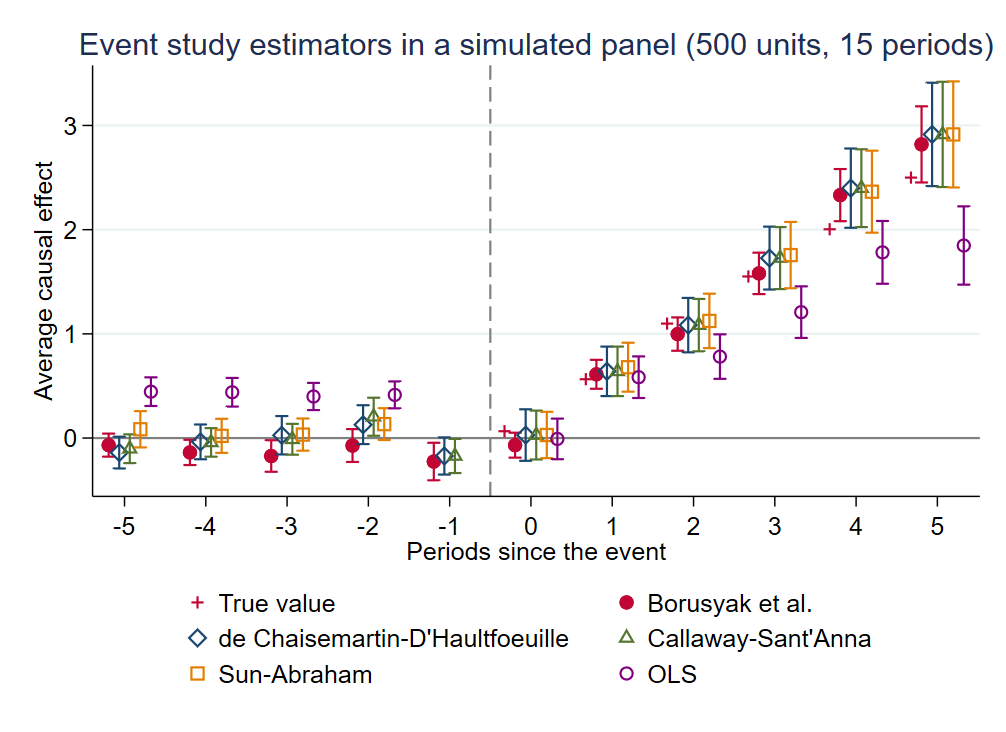